# Overview


This notebook describes the different stages to build up different deep learning models trained over the dataset called **Fakeddit** by using pretrained **Word2Vec** and **Glove** Embeddings, for the automatic fake news detection

List of Deep Learning algorithms included 
- 1D CNN
- LSTM
- BiLSTM



## 1. Loading Python libraries

In [1]:
import numpy as np
import pandas as pd
import warnings
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import json
import tensorflow_hub as hub
import tensorflow_text
import tldextract  
import warnings
warnings.filterwarnings('ignore')

from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split,StratifiedKFold,RandomizedSearchCV
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_curve, roc_auc_score,f1_score,precision_score, recall_score
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from imblearn.over_sampling import SMOTE,ADASYN
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
import re

from collections import Counter
import nltk 
import spacy
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from wordcloud import WordCloud, ImageColorGenerator,STOPWORDS
import gensim
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords
import copy
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,LancasterStemmer
from pprint import pprint


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout, Activation,Embedding,Flatten,LSTM,Bidirectional,GlobalMaxPooling1D
from tensorflow.keras.layers import Reshape,Conv1D, MaxPooling1D, Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from keras.backend import clear_session


pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_colwidth', 200)

import warnings
warnings.filterwarnings('ignore')

2022-07-11 00:00:00.398569: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-11 00:00:00.403588: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-07-11 00:00:00.403611: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /gpfs/home/psc21zcu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading 

#### Loading the Full prepared dataset - FakeNewsNet cleaned data using nltk library on earlier works

In [2]:
final_df=pd.read_csv("Updated//fakeddit_full_valid_cleaned_comment_using_nltk.csv")

***
## 2. Dataset Cleaning and Preprocessing


#### Removing the null values

In [ ]:
final_df=final_df.dropna()

***

## 3. Model Training and Evaluation


### Splitting Data into Train and Test Datasets

In [3]:
train, test = train_test_split(final_df[['fulltext','class']], test_size=0.3,stratify=final_df['class'], random_state=0)

###### Due to huge data size and memory constraint issues, here we are considering  50% portion  from the full training set and 50% from  test set  

##### Shuffling both train and test set

In [ ]:
train_filtered = train.sample(frac=.5)
test_filtered = test.sample(frac=.5)

In [4]:
train_filtered=train_filtered.reset_index(drop=True)
test_filtered=test_filtered.reset_index(drop=True)

X_train=train_filtered['fulltext']
y_train=train_filtered['class']

X_test=test_filtered['fulltext']
y_test=test_filtered['class']

since we need to pad  the sentences before feed to the model, For this, we need to find the maximum lenght of any document.

In [6]:
maxi=-1
for i,sent in enumerate(train_filtered['fulltext']):
    if(len(sent)>maxi):
        maxi=len(sent)
print(maxi)

2137


In [7]:
print("Maximum Length of the sequence : ",maxi)

Maximum Length of the sequence :  2137


#### Now we intialise Keras Tokeniser and fit on training set

In [8]:
tokenzr = Tokenizer()

In [9]:
tokenzr.fit_on_texts(final_df['fulltext'])
vocab_size = len(tokenzr.word_index) + 1

#### Encode  texts to sequence format for both training set and test set 

In [11]:
encd_train = tokenzr.texts_to_sequences(X_train)
encd_test = tokenzr.texts_to_sequences(X_test)

##### Hyperparameter Configuration Setting for the model training

In [13]:
maxi=2000  # max lenght of a news article
vocab_size = len(tokenzr.word_index) + 1  # total no of words
embed_dim=300 # embedding dimension as choosen in word2vec constructor

**Pad both training and test encoded data to maximum length variable value**

In [14]:
pad_train= pad_sequences(encd_train, maxlen=maxi, padding='post')
pad_train.shape   

(167864, 2000)

In [15]:
pad_test= pad_sequences(encd_test, maxlen=maxi, padding='post')
pad_test.shape

(71942, 2000)

####  User defined helper functions to plot training and testing accuracy of the trained model

This function is using to save the loss and accuracy metrics of the training and test sets from the given input parameter which is a keras history callback object obtained during the model traning

In [16]:
import matplotlib.pyplot as plt

    
def plot_loss_and_acc_from_hist2(hist_df):
    print('Training Accuracy :',hist_df.iloc[-1]['accuracy'])
    print('Validation Accuracy :',hist_df.iloc[-1]['val_accuracy'])
    print('Precision :',hist_df.iloc[-1]["precision"])
    print('Recall :',hist_df.iloc[-1]["recall"])
    print('F1 Score :',hist_df.iloc[-1]["f1score"])
    train_loss = hist_df["loss"]
    train_acc = hist_df["accuracy"]
    val_loss = hist_df["val_loss"]
    val_acc = hist_df["val_accuracy"]
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(121)
    ax.plot(range(len(train_loss)), train_loss, label="Train Loss");
    ax.plot(range(len(val_loss)), val_loss, label="Validation Loss");
    plt.xlabel("Epochs"); plt.ylabel("Loss");
    plt.title("Train Loss vs Validation Loss");
    plt.legend(loc="best");

    ax = fig.add_subplot(122)
    ax.plot(range(len(train_acc)), train_acc, label="Train Accuracy");
    ax.plot(range(len(val_acc)), val_acc, label="Validation Accuracy");
    plt.xlabel("Epochs"); plt.ylabel("Accuracy");
    plt.title("Train Accuracy vs Validation Accuracy");
    plt.legend(loc="best");    

    


#### User defined helper functions to create the confusion matrix and normalised confusion matrix 

The below scripts is using to create the confusion matrix and normalised confusion matrix based on the predictions and actual truth lables

In [17]:
# Helper function to plot confusion matrix and normalised confusion matrix plot
def confusn_mtrx_plot(cm,path):
    from sklearn.metrics import confusion_matrix
    # Y_pred_evc = evc_mdl.predict(test_X)
    #cm = confusion_matrix(ytrue, y_pred)

    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm, annot=True, ax=ax, cmap="GnBu", fmt="g");  
    #sns.heatmap(cm/np.sum(cm), annot=True, ax=ax[1], cmap="GnBu", fmt="g");  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'20'}  # Adjust to fit
    ax.set_title('Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    #fig.show()
    fig.savefig(path)
    
def norm_confusn_mtrx_plot(cm,path):
    fig = plt.figure(figsize=(6, 5), dpi=60)
    ax = plt.subplot()
    sns.set(font_scale=1.4) # Adjust to fit
    sns.heatmap(cm/np.sum(cm), annot=True, ax=ax, cmap="GnBu",fmt='.2%');  

    # Labels, title and ticks
    label_font = {'size':'18'}  # Adjust to fit
    ax.set_xlabel('Predicted', fontdict=label_font);
    ax.set_ylabel('Actuals', fontdict=label_font);

    title_font = {'size':'18'}  # Adjust to fit
    ax.set_title('Normalised Confusion Matrix', fontdict=title_font);

    ax.tick_params(axis='both', which='major', labelsize=15)  # Adjust to fit
    ax.xaxis.set_ticklabels(['Real', 'Fake']);
    ax.yaxis.set_ticklabels(['Real', 'Fake']);
    fig.savefig(path)

## Feature Extractions using pretrained Word2Vec model

##### Load the  pretrained model

In [18]:
!wget -P /root/input/ -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"

#### After downloading it, you can load it as follows

In [19]:
path_to_model = 'Embeddings//GoogleNews-vectors-negative300.bin'

In [20]:
from gensim.models.keyedvectors import KeyedVectors
%time w2v_model_pretrained = KeyedVectors.load_word2vec_format(path_to_model, binary=True)
print('done loading Word2Vec')

CPU times: user 19.1 s, sys: 1.6 s, total: 20.7 s
Wall time: 20.8 s
done loading Word2Vec


#### Then inspect the model by getting the list of index of key values from the pretrained model

In [22]:
# total numberof extracted words.
word2vec_vocab=w2v_model_pretrained.index_to_key
print("The total number of words are : ",len(word2vec_vocab))

The total number of words are :  3000000


In [23]:
word2vec_vocab_lower = [item.lower() for item in word2vec_vocab]

#### Finding out the number of key value pairs of  vocabulary count and save those in a dictionary

In [24]:
word_vec_dict_pre={}
for word in word2vec_vocab:
    word_vec_dict_pre[word]=w2v_model_pretrained.get_vector(word)
print("The no of key-value pairs : ",len(word_vec_dict_pre)) # should come equal to vocab size
  

The no of key-value pairs :  3000000


#### Creation of Embedding matrix which is a list of all words and their corresponding embeddings

In [26]:
# now creating the embedding matrix
embedded_matrix_2=np.zeros(shape=(vocab_size,embed_dim))
for word,i in tokenzr.word_index.items():
    embedded_vec=word_vec_dict_pre.get(word)
    if embedded_vec is not None:  # word is in the vocabulary learned by the w2v model
        embedded_matrix_2[i]=embedded_vec

***
## Model Training

### Using 1D CNN

#### Checkpoint and EarlyStopping configuration setting for the model training

In [71]:
# Model Checkpoint and EarlyStopping
filepath = "outputs//model_FAKEDDIT_CNN_WORD2VEC_PRETRAINED_V3.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

#### Build the model 

In [72]:
warnings.filterwarnings('ignore')
cnn_model=Sequential()
cnn_model.add(Embedding(vocab_size,embed_dim,input_length=maxi))
cnn_model.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu'))
cnn_model.add(Conv1D(filters=64, kernel_size=3, padding='valid', activation='relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn_model.add(MaxPooling1D())
cnn_model.add(Flatten())
cnn_model.add(Dense(128, activation='relu'))
cnn_model.add(Dropout(0.4))
cnn_model.add(Dense(64, activation='relu'))
cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(1, activation='sigmoid'))
# compile the model
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 5000, 300)         32117400  
                                                                 
 conv1d_3 (Conv1D)           (None, 4998, 128)         115328    
                                                                 
 conv1d_4 (Conv1D)           (None, 4996, 64)          24640     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 2498, 64)         0         
 1D)                                                             
                                                                 
 conv1d_5 (Conv1D)           (None, 2498, 32)          6176      
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 1249, 32)         0         
 1D)                                                  

#### Model Training 

In [79]:
history_cnn_word2vec=cnn_model.fit(pad_train,y_train,epochs=2,batch_size=256,validation_split=0.2,shuffle=True, callbacks=callbacks_list)

#### Save the callback history details to csv

In [ ]:
hist_df.to_csv("outputs//model_FAKEDDIT_CNN_WORD2VEC_history.csv",index=False)
#plot_loss_and_acc_from_hist(hist_df)
print("CNN Completed")


#### Load the trained model

In [83]:
from tensorflow.keras.models import load_model
cnn_model = load_model('outputs//fakeddit_dl_word2vec//model_FAKEDDIT_CNN_WORD2VEC_PRETRAINED_V3.h5')

#### Evaluate the predictions made based on test data and calculate  the accuracy score metrics 

In [84]:
y_pred=cnn_model.predict(pad_test)
# ytrue = y_test.astype(int).tolist()
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2249/2249 [==============================] - 76s 34ms/step


In [86]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.8758166300631064
precision = 0.9005410723069356
recall = 0.921871538198151
f1score = 0.9110814738141211
[[17238  5055]
 [ 3879 45770]]
              precision    recall  f1-score   support

           0       0.82      0.77      0.79     22293
           1       0.90      0.92      0.91     49649

    accuracy                           0.88     71942
   macro avg       0.86      0.85      0.85     71942
weighted avg       0.87      0.88      0.87     71942



**Save the classification report to csv**

In [87]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakeddit_dl_word2vec//model_FAKEDDIT_CNN_WORD2VEC_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.816309,0.773247,0.794195,22293.000000
1,0.900541,0.921872,0.911081,49649.000000
accuracy,0.875817,0.875817,0.875817,0.875817
macro avg,0.858425,0.847559,0.852638,71942.000000
weighted avg,0.874440,0.875817,0.874861,71942.000000


**Plot confusion matrix using the user defined functions created earlier**

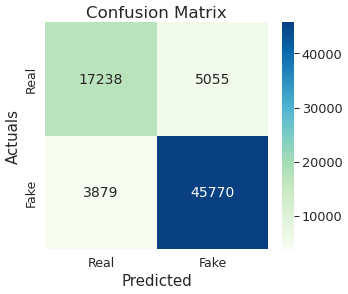

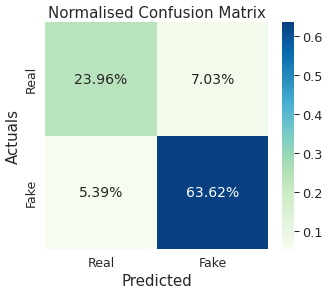

In [89]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//fakeddit_dl_word2vec//fakeddit_cnn_w2v_cmtrx.png"
path2="outputs//fakeddit_dl_word2vec//fakeddit_cnn_w2v_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

#### Plot the training and test accuracy scores from the callback history details

Training Accuracy : 0.9235466122627258
Validation Accuracy : 0.8756441473960876
Precision : 0.899615801398877
Recall : 0.9212145667305558
F1 Score : 0.9102870813397128


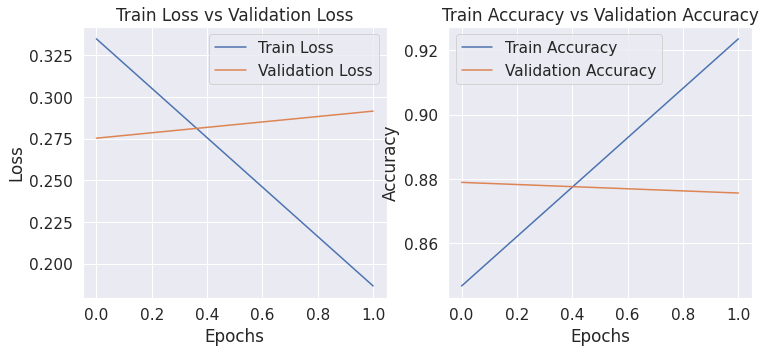

In [85]:

hist_df = pd.read_csv("outputs//fakeddit_dl_word2vec//model_FAKEDDIT_CNN_WORD2VEC_history.csv")
plot_loss_and_acc_from_hist2(hist_df)
# print("LSTM Completed")

### LSTM

#### Checkpoint and EarlyStopping configuration setting for the model training

In [37]:
# Model Checkpoint and EarlyStopping
filepath = "outputs//model_FAKEDDIT_LSTM_WORD2VEC_PRETRAINED_V2.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

#### Build the model 

In [39]:
from keras.initializers import Constant
lstm_model=Sequential()
lstm_model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=maxi,
                    embeddings_initializer=Constant(embedded_matrix_2),trainable=True))
lstm_model.add(LSTM(128,return_sequences=True,dropout=0.2)) # loss stucks at about 
lstm_model.add(GlobalMaxPooling1D())
lstm_model.add(Dense(64,activation='relu'))
lstm_model.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

# compile the model
lstm_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [40]:
lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10000, 300)        61179300  
                                                                 
 lstm (LSTM)                 (None, 10000, 128)        219648    
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 61,407,269
Trainable params: 61,407,269
Non-trainable params: 0
__________________________________________

#### Model Training 

In [32]:
history_lstm_word2vec=lstm_model.fit(pad_train,y_train,epochs=2,batch_size=256,validation_split=0.2,shuffle=True, callbacks=callbacks_list)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_135806/2769374758.py", line 1, in <module>
    history_lstm_word2vec=lstm_model.fit(pad_train,y_train,epochs=4,batch_size=500,validation_split=0.2,shuffle=True, callbacks=callbacks_list)
NameError: name 'lstm_model' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/gpfs/home/psc21zcu/.conda/envs/python37env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2077, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'NameError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/gpfs/home/psc21zcu/.conda/envs/python37env/lib/

TypeError: object of type 'NoneType' has no len()

#### Save the callback history details to csv

In [ ]:
hist_df.to_csv("outputs//model_FAKEDDIT_LSTM_WORD2VEC_history.csv",index=False)
#plot_loss_and_acc_from_hist(hist_df)
print("LSTM Completed")

#### Load the trained model

In [94]:
from tensorflow.keras.models import load_model
lstm_model = load_model('outputs//fakeddit_dl_word2vec//model_FAKEDDIT_LSTM_WORD2VEC_PRETRAINED_V3.h5')

#### Evaluate the predictions made based on test data and calculate  the accuracy score metrics 

In [95]:
y_pred=lstm_model.predict(pad_test)
# ytrue = y_test.astype(int).tolist()
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2249/2249 [==============================] - 1600s 711ms/step


In [96]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.888604709349198
precision = 0.9097045915254571
recall = 0.9309955890350259
f1score = 0.920226956002389
[[17705  4588]
 [ 3426 46223]]
              precision    recall  f1-score   support

           0       0.84      0.79      0.82     22293
           1       0.91      0.93      0.92     49649

    accuracy                           0.89     71942
   macro avg       0.87      0.86      0.87     71942
weighted avg       0.89      0.89      0.89     71942



**Save the classification report to csv**

In [97]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakeddit_dl_word2vec//model_FAKEDDIT_LSTM_WORD2VEC_clasifctnrpt.csv")

,precision,recall,f1-score,support
0,0.837869,0.794195,0.815448,22293.000000
1,0.909705,0.930996,0.920227,49649.000000
accuracy,0.888605,0.888605,0.888605,0.888605
macro avg,0.873787,0.862596,0.867837,71942.000000
weighted avg,0.887444,0.888605,0.887759,71942.000000


**Plot confusion matrix using the user defined functions created earlier**

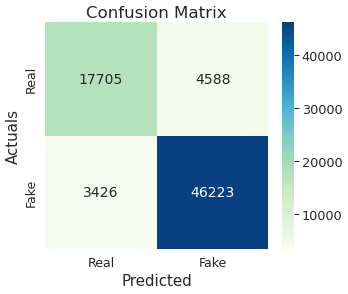

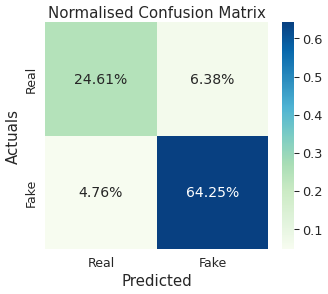

In [98]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//fakeddit_dl_word2vec//fakeddit_lstm_w2v_cmtrx.png"
path2="outputs//fakeddit_dl_word2vec//fakeddit_lstm_w2v_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

#### Plot the training and test accuracy scores from the callback history details

Training Accuracy : 0.9139108061790466
Validation Accuracy : 0.8901796340942383
Precision : 0.9098318598042312
Recall : 0.9301523252294966
F1 Score : 0.9198798846733242


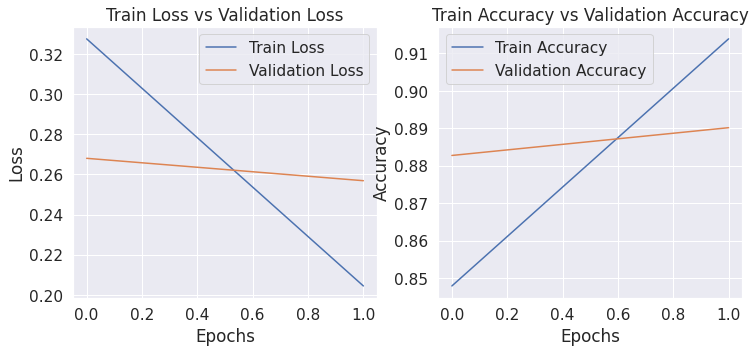

In [90]:
hist_df = pd.read_csv("outputs//fakeddit_dl_word2vec//model_FAKEDDIT_LSTM_WORD2VEC_history.csv")
plot_loss_and_acc_from_hist2(hist_df)
# print("LSTM Completed")

## Bi LSTM

#### Checkpoint and EarlyStopping configuration setting for the model training

In [ ]:
# Model Checkpoint and EarlyStopping
filepath = "outputs//fakeddit_dl_word2vec//model_FAKEDDIT_BILSTM_WORD2VEC_PRETRAINED_V3.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

#### Build the model 

In [ ]:
from keras.initializers import Constant
bilstm_model=Sequential()
bilstm_model.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=maxi,
                    embeddings_initializer=Constant(embedded_matrix_2),trainable=True))
bilstm_model.add(Bidirectional(LSTM(128,return_sequences=True,dropout=0.2))) # loss stucks at about 
bilstm_model.add(GlobalMaxPooling1D())
bilstm_model.add(Dense(64,activation='relu'))
bilstm_model.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

# compile the model
bilstm_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

#### Model Training 

In [ ]:
history_bilstm_word2vec=bilstm_model.fit(pad_train,y_train,epochs=2,batch_size=256,validation_split=0.2,shuffle=True, 
                                         callbacks=callbacks_list)

#### Save the callback history details to csv

In [ ]:
hist_df = pd.DataFrame(history_bilstm_word2vec.history) 
hist_df.to_csv("outputs//fakeddit_dl_word2vec//model_FAKEDDIT_BILSTM_WORD2VEC_history.csv",index=False)


#### Load the trained model

In [34]:
from tensorflow.keras.models import load_model
bilstm_model = load_model('outputs//fakeddit_dl_word2vec//model_FAKEDDIT_BILSTM_WORD2VEC_PRETRAINED_V3.h5')

2022-06-30 12:50:58.625736: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-06-30 12:50:58.626246: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-06-30 12:50:58.626628: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH

#### Evaluate the predictions made based on test data and calculate  the accuracy score metrics 

In [35]:
y_pred=bilstm_model.predict(pad_test)
# ytrue = y_test.astype(int).tolist()
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2249/2249 [==============================] - 2090s 929ms/step


In [36]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.8903005198632231
precision = 0.9052355110948032
recall = 0.9401311698991155
f1score = 0.922353404171586
[[17176  4907]
 [ 2985 46874]]
              precision    recall  f1-score   support

           0       0.85      0.78      0.81     22083
           1       0.91      0.94      0.92     49859

    accuracy                           0.89     71942
   macro avg       0.88      0.86      0.87     71942
weighted avg       0.89      0.89      0.89     71942



**Save the classification report to csv**

In [50]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakeddit_dl_word2vec//model_FAKEDDIT_BILSTM_WORD2VEC_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
,,,,
0,0.851942,0.777793,0.813181,22083.000000
1,0.905236,0.940131,0.922353,49859.000000
accuracy,0.890301,0.890301,0.890301,0.890301
macro avg,0.878589,0.858962,0.867767,71942.000000
weighted avg,0.888877,0.890301,0.888842,71942.000000


**Plot confusion matrix using the user defined functions created earlier**

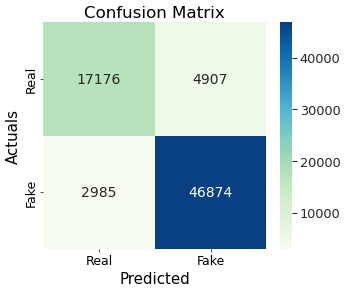

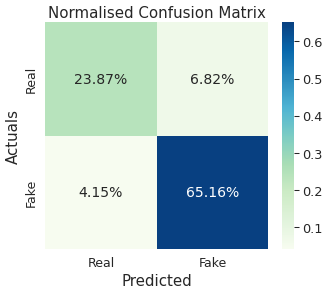

In [51]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//fakeddit_dl_word2vec//fakeddit_bilstm_w2v_cmtrx.png"
path2="outputs//fakeddit_dl_word2vec//fakeddit_bilstm_w2v_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

#### Plot the training and test accuracy scores from the callback history details

Training Accuracy : 0.9209999442100524
Validation Accuracy : 0.8908944725990295
Precision : 0.9033120278907611
Recall : 0.9409462322203168
F1 Score : 0.9217451455111416


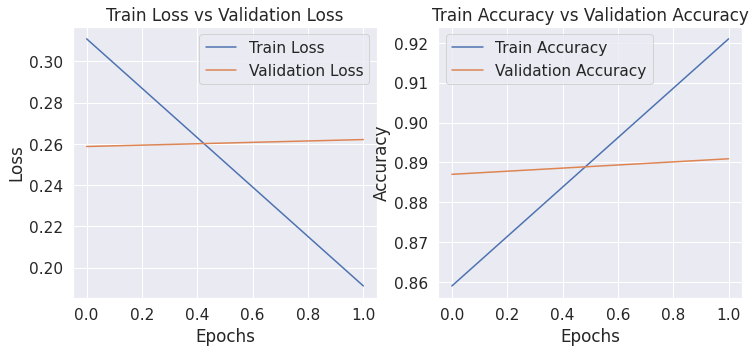

In [99]:
hist_df = pd.read_csv("outputs//fakeddit_dl_word2vec//model_FAKEDDIT_BILSTM_WORD2VEC_history.csv")
plot_loss_and_acc_from_hist2(hist_df)
# print("LSTM Completed")

## Feature Extraction Pretrained Glove

##### Download the pretrained zip file

In [44]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

#### Load the downloaded the 300 dimension Glove pretrained model "glove.6B.300d.txt" in a path and convert to word2vec format",

In [29]:
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

In [30]:
glove_path = 'Embeddings//glove.6B.300d.txt'

In [31]:
import os
glove_embeddings_index = {}
f = open(os.path.join(glove_path), encoding="utf8")

#### Finding out the number of key value pairs of  vocabulary count and save those in a dictionary

In [32]:
for line in f:
    values = line.split()
    #print(values[1:])
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    glove_embeddings_index[word] = coefs
f.close()

In [33]:
print('Total %s word vectors in Glove.' % len(glove_embeddings_index))

Total 400000 word vectors in Glove.


#### Creation of Embedding matrix which is a list of all words and their corresponding embeddings

In [34]:
embedding_gmatrix = np.random.random((len(tokenzr.word_index) + 1, embed_dim))
for word, i in tokenzr.word_index.items():
    embedding_gvector = glove_embeddings_index.get(word)
    if embedding_gvector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_gmatrix[i] = embedding_gvector

*** 
### Model Training

### 1D CNN

#### Checkpoint and EarlyStopping configuration setting for the model training

In [ ]:
# Model Checkpoint and EarlyStopping
filepath = "outputs//model_FAKEDDIT_CNN_GLOVE_V1.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

#### Build the model

In [ ]:
warnings.filterwarnings('ignore')
cnn_model_g=Sequential()
cnn_model_g.add(Embedding(vocab_size,embed_dim,input_length=maxi))
cnn_model_g.add(Conv1D(filters=128, kernel_size=3, padding='valid', activation='relu'))
cnn_model_g.add(Conv1D(filters=64, kernel_size=3, padding='valid', activation='relu'))
cnn_model_g.add(MaxPooling1D())
cnn_model_g.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn_model_g.add(MaxPooling1D())
cnn_model_g.add(Flatten())
cnn_model_g.add(Dense(128, activation='relu'))
cnn_model_g.add(Dropout(0.4))
cnn_model_g.add(Dense(64, activation='relu'))
cnn_model_g.add(Dropout(0.2))
cnn_model_g.add(Dense(1, activation='sigmoid'))
# compile the model
cnn_model_g.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(cnn_model_g.summary())

#### Model Training 

In [ ]:
history_cnn_glove=cnn_model_g.fit(pad_train,y_train,epochs=2,batch_size=128,validation_split=0.2,shuffle=True, 
                                  callbacks=callbacks_list) 

#### Save the callback history details to csv

In [ ]:
hist_df.to_csv("outputs//model_FAKEDDIT_CNN_GLOVE_V1_history.csv",index=False)
#plot_loss_and_acc_from_hist(hist_df)
print("CNN Completed")

#### Load the trained model

In [77]:
from tensorflow.keras.models import load_model
cnn_model = load_model('outputs//fakeddit_dl_glove//model_FAKEDDIT_CNN_GLOVE_V1.h5')

#### Evaluate the predictions made based on test data and calculate  the accuracy score metrics 

In [78]:
y_pred=cnn_model.predict(pad_test)
# ytrue = y_test.astype(int).tolist()
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2249/2249 [==============================] - 77s 34ms/step


In [80]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.861499541297156
precision = 0.9294262774038565
recall = 0.8649922455638582
f1score = 0.8960524119512602
[[19032  3261]
 [ 6703 42946]]
              precision    recall  f1-score   support

           0       0.74      0.85      0.79     22293
           1       0.93      0.86      0.90     49649

    accuracy                           0.86     71942
   macro avg       0.83      0.86      0.84     71942
weighted avg       0.87      0.86      0.86     71942



**Save the classification report to csv**

In [81]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakeddit_dl_glove//model_FAKEDDIT_CNN_GLOVE_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.739538,0.853721,0.792538,22293.0000
1,0.929426,0.864992,0.896052,49649.0000
accuracy,0.861500,0.861500,0.861500,0.8615
macro avg,0.834482,0.859357,0.844295,71942.0000
weighted avg,0.870585,0.861500,0.863976,71942.0000


**Plot confusion matrix using the user defined functions created earlier**

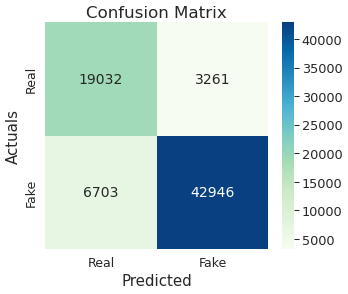

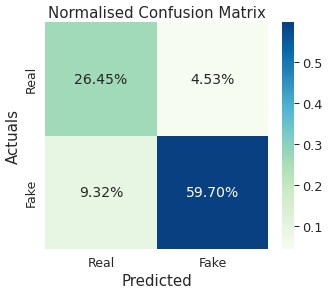

In [82]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//fakeddit_dl_glove//fakeddit_cnn_cmtrx.png"
path2="outputs//fakeddit_dl_glove//fakeddit_cnn_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

#### Plot the training and test accuracy scores from the callback history details

Training Accuracy : 0.9228392243385316
Validation Accuracy : 0.8612575531005859
Precision : 0.9317023665572638
Recall : 0.8644149287817777
F1 Score : 0.8967982624780472


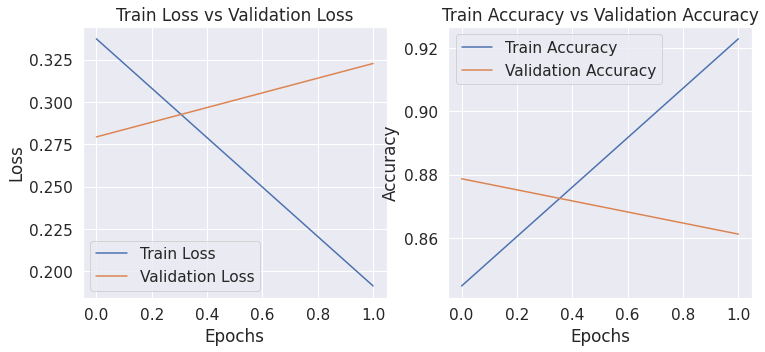

In [79]:
hist_df = pd.read_csv("outputs//fakeddit_dl_glove//model_FAKEDDIT_CNN_GLOVE_V1_history.csv")
plot_loss_and_acc_from_hist2(hist_df)
# print("CNN Completed")

### LSTM

#### Checkpoint and EarlyStopping configuration setting for the model training

In [ ]:
# Model Checkpoint and EarlyStopping
filepath = "outputs//model_FAKEDDIT_LSTM_GLOVE_PRETRAINED_V2.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

#### Build the model

In [ ]:
from keras.initializers import Constant
lstm_model_g=Sequential()
lstm_model_g.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=maxi,
                    embeddings_initializer=Constant(embedding_gmatrix),trainable=True))
lstm_model_g.add(LSTM(128,return_sequences=True,dropout=0.2)) # loss stucks at about 
lstm_model_g.add(GlobalMaxPooling1D())
lstm_model_g.add(Dense(64,activation='relu'))
lstm_model_g.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

# compile the model
lstm_model_g.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
print(lstm_model_g.summary())

#### Model Training 

In [ ]:
history_lstm_glove=lstm_model_g.fit(pad_train,y_train,epochs=2,batch_size=256,validation_split=0.2,shuffle=True, 
                                    callbacks=callbacks_list) 

#### Save the callback history details to csv

In [ ]:
hist_df = pd.DataFrame(history_lstm_glove.history) 
hist_df.to_csv("outputs//model_FAKEDDIT_LSTM_GLOVE_V1_history.csv",index=False)
#plot_loss_and_acc_from_hist(hist_df)
print("LSTM Completed")

#### Load the trained model

In [72]:
from tensorflow.keras.models import load_model
lstm_model = load_model('outputs//fakeddit_dl_glove//model_FAKEDDIT_LSTM_GLOVE_PRETRAINED_V2.h5')

#### Evaluate the predictions made based on test data and calculate  the accuracy score metrics 

In [73]:
y_pred=lstm_model.predict(pad_test)
# ytrue = y_test.astype(int).tolist()
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2249/2249 [==============================] - 1256s 558ms/step


In [74]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

Accuracy score : 0.8909260237413472
precision = 0.8966636301525849
recall = 0.9516203750327298
f1score = 0.9233249626249499
[[16848  5445]
 [ 2402 47247]]
              precision    recall  f1-score   support

           0       0.88      0.76      0.81     22293
           1       0.90      0.95      0.92     49649

    accuracy                           0.89     71942
   macro avg       0.89      0.85      0.87     71942
weighted avg       0.89      0.89      0.89     71942



**Save the classification report to csv**

In [75]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakeddit_dl_glove//model_FAKEDDIT_LSTM_GLOVE_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.875221,0.755753,0.811111,22293.000000
1,0.896664,0.951620,0.923325,49649.000000
accuracy,0.890926,0.890926,0.890926,0.890926
macro avg,0.885942,0.853687,0.867218,71942.000000
weighted avg,0.890019,0.890926,0.888553,71942.000000


**Plot confusion matrix using the user defined functions created earlier**

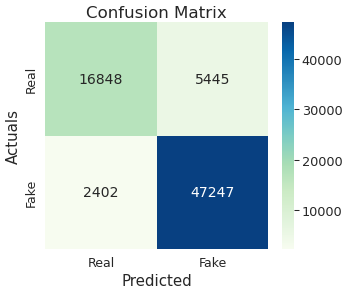

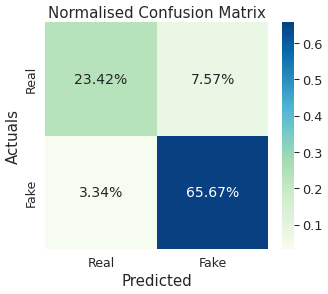

In [76]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//fakeddit_dl_glove//fakeddit_lstm_cmtrx.png"
path2="outputs//fakeddit_dl_glove//fakeddit_lstm_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

#### Plot the training and test accuracy scores from the callback history details

Training Accuracy : 0.907745122909546
Validation Accuracy : 0.8938432931900024
Precision : 0.8985735124178301
Recall : 0.9502373940741632
F1 Score : 0.9236835955756348


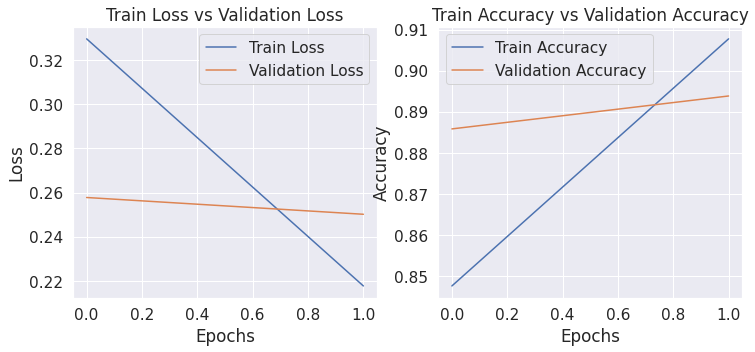

In [71]:
hist_df = pd.read_csv("outputs//fakeddit_dl_glove//model_FAKEDDIT_LSTM_GLOVE_V1_history.csv")
plot_loss_and_acc_from_hist2(hist_df)
# print("LSTM Completed")

## BILSTM
#### Checkpoint and EarlyStopping configuration setting for the model training

In [35]:
# Model Checkpoint and EarlyStopping
filepath = "outputs//model_FAKEDDIT_BILSTM_GLOVE_PRETRAINED_V2.h5" # Location to get the model
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', patience=3,mode='min', verbose=1)
callbacks_list = [checkpoint,es]

#### Build the model

In [ ]:
from keras.initializers import Constant
bilstm_model_g=Sequential()
bilstm_model_g.add(Embedding(input_dim=vocab_size,output_dim=embed_dim,input_length=maxi,
                    embeddings_initializer=Constant(embedding_gmatrix),trainable=True))
bilstm_model_g.add(Bidirectional(LSTM(128,return_sequences=True,dropout=0.2))) # loss stucks at about 
bilstm_model_g.add(GlobalMaxPooling1D())
bilstm_model_g.add(Dense(64,activation='relu'))
bilstm_model_g.add(Dense(1,activation='sigmoid'))  # sigmod for bin. classification.

# compile the model
bilstm_model_g.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
print(bilstm_model_g.summary())


#### Model Training 

In [ ]:
history_bilstm_glove=bilstm_model_g.fit(pad_train,y_train,epochs=2,batch_size=256,
                                        validation_split=0.2,shuffle=True, callbacks=callbacks_list) 

#### Save the callback history details to csv

In [ ]:
hist_df = pd.DataFrame(history_bilstm_glove.history) 
hist_df.to_csv("outputs//model_FAKEDDIT_BILSTM_GLOVE_V1_history.csv",index=False)
#plot_loss_and_acc_from_hist(hist_df)
print("BILSTM Completed")

#### Load the trained model

In [36]:
from tensorflow.keras.models import load_model
bilstm_model = load_model('outputs//fakeddit_dl_glove//model_FAKEDDIT_BILSTM_GLOVE_PRETRAINED_V2.h5')

2022-06-30 09:49:51.985637: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-06-30 09:49:51.986056: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /gpfs/software/ada/python/anaconda/2020.11/3.8/lib:/gpfs/software/ada/cuda/10.2.89/lib64:/gpfs/software/ada/cuda/10.2.89/lib/lib64
2022-06-30 09:49:51.986396: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH

#### Evaluate the predictions made based on test data and calculate  the accuracy score metrics 

In [37]:
y_pred=bilstm_model.predict(pad_test)
# ytrue = y_test.astype(int).tolist()
ytrue = y_test.values
y_pred2 = np.array((y_pred > 0.5).astype(int)[:,0])
precision = precision_score(ytrue, y_pred2)
recall = recall_score(ytrue, y_pred2)
f1score = f1_score(ytrue, y_pred2)

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2249/2249 [==============================] - 1840s 817ms/step


In [60]:
print("Accuracy score : {}".format(accuracy_score(ytrue, y_pred2)))

Accuracy score : 0.8931222373578717


In [56]:
print('precision =',precision)
print('recall =',recall)
print('f1score =',f1score)

precision = 0.9107282693813625
recall = 0.936977582630063
f1score = 0.9236664714233239


In [59]:
print(confusion_matrix(ytrue, y_pred2))
print(classification_report(ytrue, y_pred2))

[[17733  4560]
 [ 3129 46520]]
              precision    recall  f1-score   support

           0       0.85      0.80      0.82     22293
           1       0.91      0.94      0.92     49649

    accuracy                           0.89     71942
   macro avg       0.88      0.87      0.87     71942
weighted avg       0.89      0.89      0.89     71942



**Save the classification report to csv**

In [61]:
report=classification_report(ytrue, y_pred2, output_dict=True)
df = pd.DataFrame(report).transpose()
df.to_csv("outputs//fakeddit_dl_glove//model_FAKEDDIT_BILSTM_GLOVE_clasifctnrpt.csv")
df.head()

,precision,recall,f1-score,support
0,0.850014,0.795451,0.821828,22293.000000
1,0.910728,0.936978,0.923666,49649.000000
accuracy,0.893122,0.893122,0.893122,0.893122
macro avg,0.880371,0.866215,0.872747,71942.000000
weighted avg,0.891915,0.893122,0.892109,71942.000000


**Plot confusion matrix using the user defined functions created earlier**

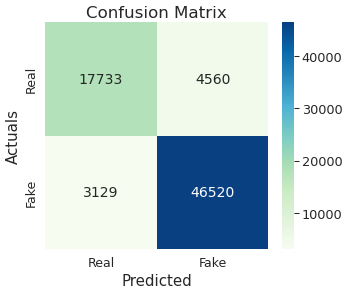

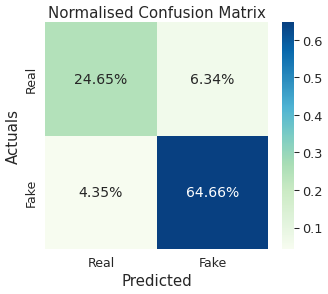

In [70]:
cm=confusion_matrix(ytrue, y_pred2)
path1="outputs//fakeddit_dl_glove//fakeddit_bilstm_cmtrx.png"
path2="outputs//fakeddit_dl_glove//fakeddit_bilstm_ncmtrx.png"
confusn_mtrx_plot(cm,path1)
norm_confusn_mtrx_plot(cm,path2)

#### Plot the training and test accuracy scores from the callback history details

Training Accuracy : 0.912875771522522
Validation Accuracy : 0.8922050595283508
Precision : 0.922379637411454
Recall : 0.9223611805902951
F1 Score : 0.9223704089085434


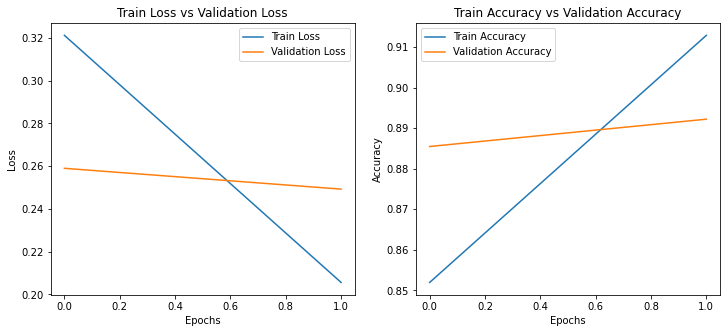

In [31]:
hist_df = pd.read_csv("outputs//fakeddit_dl_glove//model_FAKEDDIT_BILSTM_GLOVE_V1_history.csv")
plot_loss_and_acc_from_hist2(hist_df)
# print("BiLSTM Completed")